<a href="https://colab.research.google.com/github/MehdiMaboudi/2021-issdl-gdansk/blob/main/Assignments/Assignment02_KNN/KNN_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

[<img align="right" width="400" height="400" src="https://github.com/ML-IGP-TUBS-2024/Trang-Vinh-Nghi/blob/master/Assignments/Assignment02_KNN/assets/TUBS_IGP_logo.jpg?raw=1">](https://www.tu-braunschweig.de/en/)

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) ([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de))

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)  


**k-Nearest Neighbor (kNN) exercise**  
Complete and hand in this worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

The kNN classifier consists of two stages:

During training, the classifier takes the training data and simply remembers it  
During testing, kNN classifies every test sample by comparing to all training samples and transfering the labels of the k most similar training examples  
The value of k is cross-validated  
In this exercise you will implement these steps and understand the basic classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.
***

In this exercise you will:
- get familiar with [**Iris dataset**](https://en.wikipedia.org/wiki/Iris_flower_data_set)
    
- implement a fully-vectorized **kNN**
- use a validation set to *tune the learning hyperparameter(s)*
- use cross validation to *tune the learning hyperparameter(s)*

# Setup

In [ ]:
# Run some setup code for this notebook.
import numpy as np
import matplotlib.pyplot as plt
from os.path  import join
import pandas as pd


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

seed = 57  # to make this notebook's output stable across runs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

Clear previously loaded data.


# Data set

The famous [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) first used in R.A. Fisher's classic 1936 paper, [The Use of Multiple Measurements in Taxonomic Problems](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-1809.1936.tb02137.x)  
and can also be found on the UCI Machine Learning [Repository](http://archive.ics.uci.edu/ml/index.php).


[SKlearn](https://scikit-learn.org/stable/datasets/index.html#iris-dataset)

In this dataset 4 charachteristics (features) of the 150 flowers (samples) are measured.  
There are 3 different classes of Iris (0 setosa, 1 versicolour, 2 virginica)  
Features include sepal lenght, sepal width, petal lenght, petal width.

## Loading Iris dataset

There are different possibilities for loading Iris dataset:
- from [source on web](http://archive.ics.uci.edu/ml/datasets/Iris)
- from a local .csv file
- from ML libraries like [scikit-learn](https://scikit-learn.org)
  or [seaborn](https://seaborn.pydata.org/index.html)

In [ ]:
from sklearn.datasets import load_iris
'''
we can directly use the following line to load X,y of iris dataset
#X,y = load_iris(return_X_y=True)
instead we load iris dataset as a dataframe.
iris, and iris_df will be used just for explaining dataframe methods
They could also be used for visualizations.
For processing we will use just X,y as feature vectors a nd targets
'''
iris = load_iris(as_frame=True)
iris_df = iris.frame

X = iris.data.to_numpy()
y = iris.target.to_numpy()

## Visualize the dataset

In [ ]:
iris_df.head()
print(iris_df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  

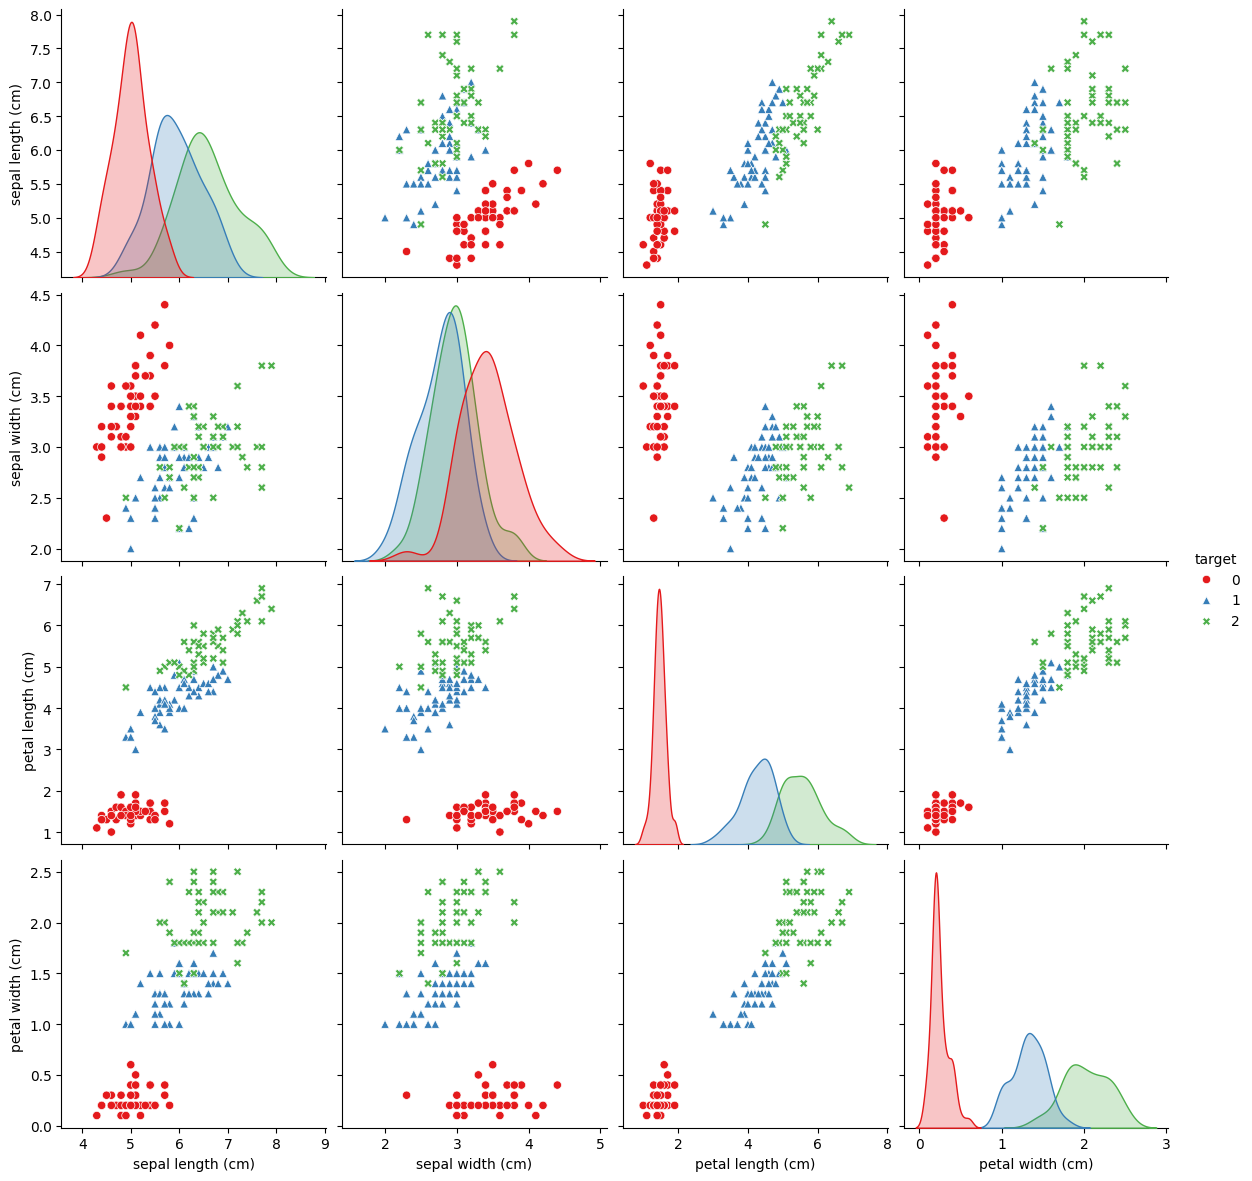

In [ ]:
import seaborn as sns
sns.color_palette("hls", 8)

sns.pairplot(data=iris_df,
             hue="target",
             height = 3,
            markers=["o", "^", "X"],
            palette = "Set1")# or 'Set2' or 'pastel'

visible patterns in the dataset:
- We can see high correlation between petal_width and petal_height
- setosa is separable even just with a threshold on petal_width or height

$\color{blue}{\text{Do you see more patterns in the dataset?}}$  
<font color='red'>Your answer:
- Setosa has the smallest petal size (both length and width)
- Setosa has wider but shorter sepals compared to other species
- Virginica generally has the largest measurements across all features
- Versicolor tends to have intermediate values between Setosa and Virginica</font>

## Data preparation and preprocessing

We need to split the dataset `(X,y)` to *trainSet* and *testSet*.     

We will use trainSet for our implementation.  
<font color='black'>The testSet should be held out for final evaluation</font>

But for hyperparameter tuning we need another set.  
So, after splitting our dataset into trainSet and testSet,  
we will further split the trainSet to two sets for training and validation

Scikitlearn has a function for this:
[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)  
But, in this assignment you should write your own function using numpy and plain python

### Split data into train, and test set

Open `TUBS_1120019/data_utils.py` and implement the function `split_into_2_sets`

In [ ]:
from TUBS_1120019.data_utils import split_into_2_sets
X_trainSet, X_testSet, y_trainSet, y_testSet   = split_into_2_sets(X, y, first_set_size=0.8,shuffle=True, random_state=seed)

# As a sanity check of loading the dataset, we print out the size of the training and test data.
print('Training data shape: ', X_trainSet.shape,X_trainSet.dtype)
print('Training labels shape: ', y_trainSet.shape,y_trainSet.dtype)
print('Test data shape: ', X_testSet.shape,X_testSet.dtype)
print('Test labels shape: ', y_testSet.shape,y_testSet.dtype)



Training data shape:  (120, 4) float64
Training labels shape:  (120,) int64
Test data shape:  (30, 4) float64
Test labels shape:  (30,) int64


### Split the training data into train, and validation set

In [ ]:
X_train, X_val, y_train, y_val   = split_into_2_sets(X_trainSet, y_trainSet, first_set_size=4/6,shuffle=False, random_state=seed)
X_test = X_testSet
y_test = y_testSet

In [ ]:
# As a sanity check, we print out the size of the training, validation and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (80, 4)
Training labels shape:  (80,)
Validation data shape:  (40, 4)
Validation labels shape:  (40,)
Test data shape:  (30, 4)
Test labels shape:  (30,)


**Note**:  
training proceeds on the training set, after which evaluation is done on the validation set,  
and when the experiment seems to be successful, final evaluation can be done on the test set.

Before starting any processing let's just do a random guess for the labels of the sample   
if we have K classes, the accuracy of the results should be around 1/K which in this case is 1/3

Using iris dataset and having a small training set, results are a bit different


In [ ]:
K = np.max(y_trainSet)+1 # Number of classes
print('Number of classes: ', K)
y_train_predicted_random = np.random.randint(K,size=X_train.shape[0],dtype=int)
print("Accuracy of random classification: ",np.mean(y_train_predicted_random==y_train))

Number of classes:  3
Accuracy of random classification:  0.45


# kNN

## Training!

In [ ]:
from TUBS_1120019.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

## Prediction

After training! we would now like to predict the label of(classify) the `query data` with the kNN classifier.

Recall that we can break down this process into two steps:

1. First we must compute the distances between all query examples and all train examples.
2. Given these distances, for each query example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and query examples. For example, if there are **Ntr** training examples and **Nq** query examples, this stage should result in a **Nq x Ntr** matrix where each element (i,j) is the distance between the i-th query and j-th train example.

### Naive implementation

First, open `TUBS_1120019/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (query, train) examples and computes the distance matrix one element at a time.

Let's consider the validation set as query data to predict the labels of validation samples.

In [ ]:
# Open TUBS_1120019/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists_val_2loops = classifier.compute_distances_two_loops(X_val)
print(dists_val_2loops.shape)

40
80
(40, 80)


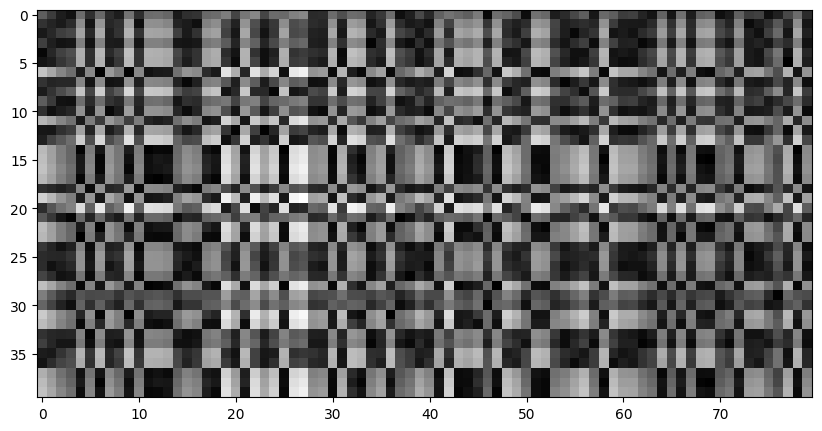

(40, 80)


In [ ]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists_val_2loops, interpolation='none')

plt.show()
print(dists_val_2loops.shape)

In [ ]:
# Using another dataset and having a lot of samples,
# if you run this cell (before implementing the function predict_labels),
# you will get the accuracy about 1/K where K is number of classes
# Using iris dataset and having a small training set, results are a bit different

# Implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_val_pred = classifier.predict_labels(dists_val_2loops, k=1)
num_val = y_val.shape[0]
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_val_pred == y_val)
accuracy = float(num_correct) / num_val
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_val, accuracy))

Got 37 / 40 correct => accuracy: 0.925000


You should expect to see approximately `95%` accuracy. Now lets try out a larger `k`, say `k = 15`:

In [ ]:
y_val_pred = classifier.predict_labels(dists_val_2loops, k=15)
num_val = y_val.shape[0]
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_val == y_val_pred)
accuracy = float(num_correct) / num_val
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_val, accuracy))

Got 37 / 40 correct => accuracy: 0.925000


You should expect to see a 100% with `k = 15`.

### Semi-vectorized implementation

After ensuring that we have an implementation (which is too inefficient)
now we can improve our implementation. The main buttleneck is
distance matrix computation.
In this step we will implement a partial vectorized version with one loop.
Implement the function `compute_distances_one_loop` and run the code below:

In [ ]:
dists_val_1loop = classifier.compute_distances_one_loop(X_val)

# To ensure that our semi-vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists_val_2loops - dists_val_1loop, ord='fro')
print('One loop difference is: %f' % (difference, ))
if difference < 1e-4:
    print('Good! The distance matrices are the same.')
else:
    print('The distance matrices are different. Check your code')

One loop difference is: 0.000000
Good! The distance matrices are the same.


### Vectorized implementation

In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code below:
dists_val_vectorized = classifier.compute_distances_no_loops(X_val)

difference = np.linalg.norm(dists_val_2loops - dists_val_vectorized, ord='fro')
print('Vectorized version difference is: %f' % (difference, ))
if difference < 1e-4:
    print('Good! The distance matrices are the same.')
else:
    print('The distance matrices are different. Check your code')

Vectorized version difference is: 0.000000
Good! The distance matrices are the same.


## Validation

In [ ]:
k_choices = sorted([1, 3, 5, 8, 10, 12, 15, 20, 50, 100])

# A dictionary holding the accuracies for different values of k that we find
# when running validation. After running validation, k_accuracies[k] should be
# a list giving the different accuracy values for different values of k.
k_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform validation to find the best value of k.                              #
# For each possible value of k,run the k-nearest-neighbor algorithm.           #
# Store the accuracies for values of k in the k_accuracies dictionary.         #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Create and train the KNN classifier
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

# Try each k value
for k in k_choices:
    print(f'Computing accuracy for k = {k}...')

    # Make predictions on validation set
    y_pred = classifier.predict(X_val, k=k, num_loops=0)  # Using no-loop version for speed

    # Compute and store accuracy
    accuracy = np.mean(y_pred == y_val)
    k_accuracies[k] = accuracy

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_accuracies.keys()):
    print('k = %d, accuracy = %f' % (k, k_accuracies[k]))

Computing accuracy for k = 1...
Computing accuracy for k = 3...
Computing accuracy for k = 5...
Computing accuracy for k = 8...
Computing accuracy for k = 10...
Computing accuracy for k = 12...
Computing accuracy for k = 15...
Computing accuracy for k = 20...
Computing accuracy for k = 50...
Computing accuracy for k = 100...
k = 1, accuracy = 0.925000
k = 3, accuracy = 0.950000
k = 5, accuracy = 0.950000
k = 8, accuracy = 0.950000
k = 10, accuracy = 0.950000
k = 12, accuracy = 0.950000
k = 15, accuracy = 0.925000
k = 20, accuracy = 0.925000
k = 50, accuracy = 0.725000
k = 100, accuracy = 0.250000


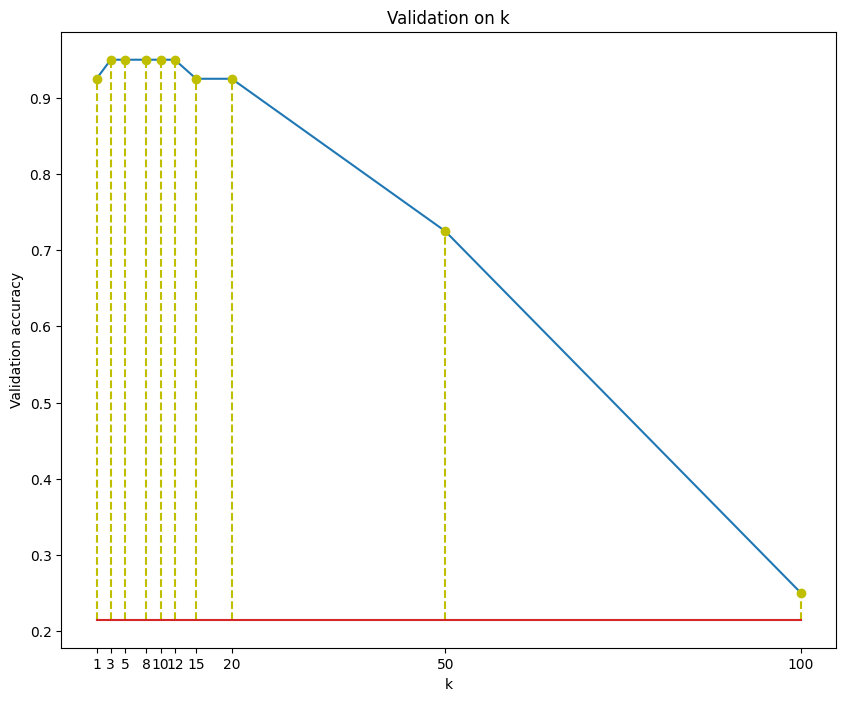

In [ ]:
# plot the observations
plt.plot(*zip(*sorted(k_accuracies.items())))
plt.stem(*zip(*sorted(k_accuracies.items())),
         bottom=plt.gca().get_ylim()[0],
         linefmt='y--',)
plt.title('Validation on k')
plt.xlabel('k')
plt.ylabel('Validation accuracy')
plt.xticks (k_choices)
plt.show()

In [ ]:
# Based on the validation results above, choose the best value for k
best_k_validation  = max(k_accuracies, key=k_accuracies.get)
print("Best k is:",best_k_validation)
print("validation accuracy:",k_accuracies[best_k_validation])

Best k is: 3
validation accuracy: 0.95


## Cross validation

By partitioning the available data into three sets (train,validation and test),  
we drastically reduce the number of samples which can be used for learning the model,  
and the results can depend on a particular random choice for the pair of (train, validation) sets.  

**A solution to this problem** is a procedure called **cross-validation** (CV for short).  
<font color='red'>The test set should still be held out for final evaluation</font>, but fixed validation set is no longer needed when doing CV.  

In the basic approach, called k-fold CV, the training set is split into k smaller sets.  
The following procedure is followed for each of the k “folds”:

- A model is trained using k-1 of the folds as training data;

- The resulting model is validated on the remaining part of the data (i.e., it is used to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop.  
This approach can be computationally expensive, but  
does not waste too much data (as is the case when fixing an arbitrary validation set),
which is a major advantage in problems **where the number of samples is very small**.


**Another benefit** of using cross validation is that:  
we can also compute the confidence interval of the estimated performance score (e.g. accuracy)

Let's also check cross validation for tuning the hyperparametrs.  
First we should combine training and validation set (Which we already splitted in two sets)

In [ ]:
X_tr = np.concatenate((X_train, X_val), axis=0)
y_tr = np.concatenate((y_train, y_val), axis=0)

# As a sanity check of loading the dataset, we print out the size of the training and test data.
print('Training data shape: ', X_tr.shape,X_tr.dtype)
print('Training labels shape: ', y_tr.shape,y_tr.dtype)

Training data shape:  (120, 4) float64
Training labels shape:  (120,) int64


In [ ]:
# Provided as a reference. You may or may not want to change them
num_folds = 5
k_choices = sorted([1, 3, 5, 8, 10, 12, 15, 20, 50, 100])

X_train_folds = []
y_train_folds = []
X_val_folds = []
y_val_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Create indices for cross-validation folds
# Create a random permutation of indices
indices = np.random.permutation(X_tr.shape[0])

# Split X_train into folds
X_train_folds = np.array_split(X_tr[indices], num_folds)

# Split y_train into folds
y_train_folds = np.array_split(y_tr[indices], num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:
    print(f'Computing accuracy for k = {k}')
    k_to_accuracies[k] = []
    for f in range(num_folds):
        # Get the current validation fold
        X_val = X_train_folds[f]
        y_val = y_train_folds[f]

        # Combine all other folds for training
        # Use list comprehension to get all folds except the current one
        X_train = np.concatenate([X_train_folds[i] for i in range(num_folds) if i != f])
        y_train = np.concatenate([y_train_folds[i] for i in range(num_folds) if i != f])

        # Create and train a new classifier
        classifier = KNearestNeighbor()
        classifier.train(X_train, y_train)

        # Make predictions on validation fold
        y_pred = classifier.predict(X_val, k=k, num_loops=0)  # Use no-loops version for speed

        # Compute accuracy
        accuracy = np.mean(y_pred == y_val)

        # Store the accuracy
        k_to_accuracies[k].append(accuracy)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Computing accuracy for k = 1
Computing accuracy for k = 3
Computing accuracy for k = 5
Computing accuracy for k = 8
Computing accuracy for k = 10
Computing accuracy for k = 12
Computing accuracy for k = 15
Computing accuracy for k = 20
Computing accuracy for k = 50
Computing accuracy for k = 100
k = 1, accuracy = 0.958333
k = 1, accuracy = 0.958333
k = 1, accuracy = 0.958333
k = 1, accuracy = 0.916667
k = 1, accuracy = 0.958333
k = 3, accuracy = 1.000000
k = 3, accuracy = 0.958333
k = 3, accuracy = 0.958333
k = 3, accuracy = 0.958333
k = 3, accuracy = 0.958333
k = 5, accuracy = 1.000000
k = 5, accuracy = 0.958333
k = 5, accuracy = 0.958333
k = 5, accuracy = 0.916667
k = 5, accuracy = 0.958333
k = 8, accuracy = 0.958333
k = 8, accuracy = 0.958333
k = 8, accuracy = 0.958333
k = 8, accuracy = 0.916667
k = 8, accuracy = 0.958333
k = 10, accuracy = 0.958333
k = 10, accuracy = 0.958333
k = 10, accuracy = 0.958333
k = 10, accuracy = 0.875000
k = 10, accuracy = 0.916667
k = 12, accuracy = 0.95

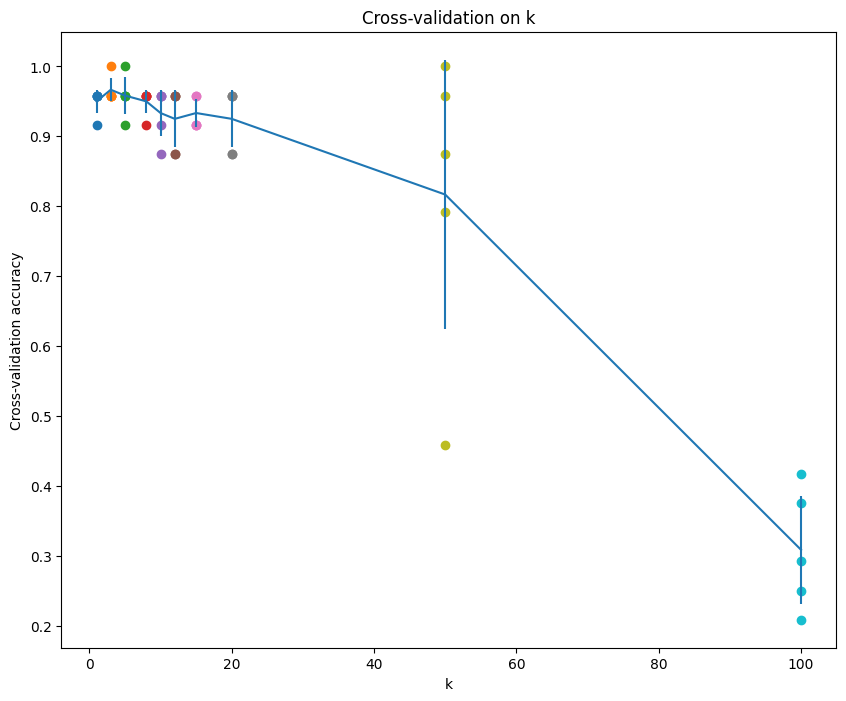

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k
best_k_cross_validation = k_choices[np.argmax(accuracies_mean)]
print("Best k is:",best_k_cross_validation)
print("Cross validation accuracy:",np.max(accuracies_mean))

Best k is: 3
Cross validation accuracy: 0.9666666666666668


## Report the final results on test data

In [ ]:
# retrain the classifier using all the training data
classifier = KNearestNeighbor()
classifier.train(X_tr, y_tr)

In [ ]:
# predict the label of the test data and report it as your final result
# You should be able to get above 81% accuracy on the test data.
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

y_test_pred = classifier.predict(X_test,k=3,num_loops=0)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_test = X_test.shape[0]
# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) /num_test
print(f'Test set results(parameters tuned by {num_folds}-fold cross-validation):\
Got {num_correct:d} / {num_test:d} correct => accuracy: {accuracy:f}')

# let's check what happen with validation(instead of cross validation)
if best_k_cross_validation != best_k_validation:
    y_test_pred = classifier.predict(X_test, k=best_k_validation)
    # Compute and display the accuracy
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) /num_test
    print('Test set results(parameters tuned by              validation):'+\
          'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
else:
    print('Got the same results using validation (NOT cross validation)')

Test set results(parameters tuned by 5-fold cross-validation):Got 29 / 30 correct => accuracy: 0.966667
Got the same results using validation (NOT cross validation)


If you reduce the number of training samples, you may see the different accuracy values!  

We can achieve more than 96%  test set accuracy on Iris dataset

*However:*
This is a simple dataset and we used it just to test our implementation
***

**Inline Questions**

Which of the following statements are true? Write your answer and explanation  
1. The decision boundary of the k-NN classifier is linear.  
$\color{blue}{\textit Your Answer: False}$  
$\color{blue}{\textit Your Explanation:Becaise the decision boundary of the k-NN classification is dependant on the local distribution of data, this leads to complex, non linear boundaries}$

2. The training error of a 1-NN will always be lower than that of 5-NN.  
$\color{blue}{\textit Your Answer:True}$  
$\color{blue}{\textit Your Explanation: For 1-NN, the program will have 0 error because the point it self is the nearest neighbour, for 5-NN it is dependant on the nearby for the majority voting, leading to some erorr during training}$

3. The test error of a 1-NN will always be lower than that of a 5-NN.  
$\color{blue}{\textit Your Answer: False}$  
$\color{blue}{\textit Your Explanation: 1-NN may lead to over fitting of the datasets and for outliers cases, will wrongly determine the class of a test sample}$

4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.  
$\color{blue}{\textit Your Answer: True}$  
$\color{blue}{\textit Your Explanation: k-NN must compute distances to all training points to find the k nearest neighbors. As the training set grows, more distance calculations are needed, increasing classification time linearly with the training set size.}$

5. L2 distance always work better than L1 distance, but its computation cost is higher.  
$\color{blue}{\textit Your Answer:False}$  
$\color{blue}{\textit Your Explanation:Neither distance metric is universally better - it depends on the specific problem and data characteristics}$

6. Which part of kNN changes, if we do not set or change the random seed?  
$\color{blue}{\textit Your Answer:The cross -validation folds}$  
$\color{blue}{\textit Your Explanation:The random seed affects how the data is split into folds during cross-validation}$

***
**Select one of the topics below and implement it:**
- Visualize the decision boundary of kNN on iris dataset
- Check your implementation with scikitlearn      

## Visualize the decision boundary of kNN on iris dataset

Using the best selected hyperparameters, visualize the decision boundary of your kNN on iris data

Accuracy: 0.9667


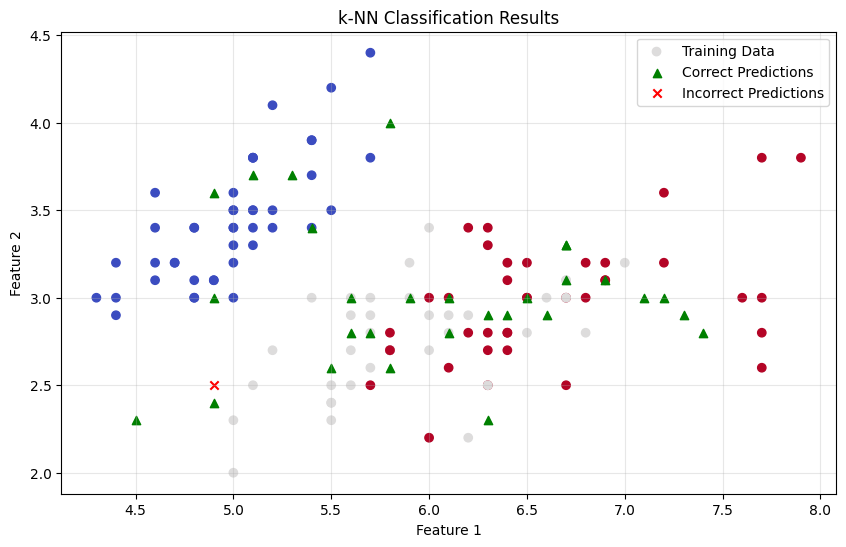

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_knn_results(X_train, X_test, y_train, y_test, y_pred):
    plt.figure(figsize=(10, 6))

    # Plot training data
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
               cmap='coolwarm', marker='o', label='Training Data', alpha=1)

    # Plot test data with predictions
    correct = y_test == y_pred

    # Plot correct predictions
    plt.scatter(X_test[correct, 0], X_test[correct, 1],
               c='green', marker='^', label='Correct Predictions', alpha=1)

    # Plot incorrect predictions
    plt.scatter(X_test[~correct, 0], X_test[~correct, 1],
               c='red', marker='x', label='Incorrect Predictions', alpha=1)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('k-NN Classification Results')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

seed = 42
# Split data into train and test sets
X_train, X_test, y_train, y_test = split_into_2_sets(X, y, first_set_size=0.8, shuffle=True, random_state=seed)

# Create and train the classifier
classifier2 = KNearestNeighbor()
classifier2.train(X_train, y_train)

# Make predictions
z = classifier2.predict(X_test, num_loops=0, k=3)
acc = np.mean(z == y_test)
print(f"Accuracy: {acc:.4f}")

# Visualize the results
plot_knn_results(X_train, X_test, y_train, y_test, z)

## Check your implementation with scikitlearn

Use scikitlearn for solving iris classification problem

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn import datasets

# load the data
X, y = datasets.load_iris(return_X_y=True)

# split data into training and test sets
X_train, X_test, y_train, y_test = split_into_2_sets(X, y,shuffle=True, first_set_size=0.8, random_state=42)



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# create KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# train the model on the training data
knn.fit(X_train, y_train)

# make predictions on the test data
y_pred = knn.predict(X_test)

# evaluate the model's performance
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9666666666666667
